<a href="https://colab.research.google.com/github/nimarez/DiffusionSat/blob/main/notebooks/single-image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import sys
sys.path.append('..')

import argparse
import logging
import math
import os
import random
import webdataset as wds
from pathlib import Path
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pyproj import Geod
from shapely.geometry import shape as shapey
from shapely.wkt import loads as shape_loads

import torch
from torchvision import transforms

from diffusionsat import (
    SatUNet, DiffusionSatPipeline,
    SampleEqually,
    fmow_tokenize_caption, fmow_numerical_metadata,
    spacenet_tokenize_caption, spacenet_numerical_metadata,
    satlas_tokenize_caption, satlas_numerical_metadata,
    combine_text_and_metadata, metadata_normalize,
)

In [2]:
# cache location
os.environ["HF_HOME"] = "./.cache/"

# Change caption/metadata here

In [3]:
caption = "a fmow satellite image of a amusement park in Australia"
# Normalized metadata: [longitude, latitude, gsd, cloud cover, year, month, day]
metadata = [ 925.8798,  345.2111, 411.4541,    0.0000,  308.3333,  166.6667, 354.8387]

# Or provide metadata values and then normalize
caption = "a fmow satellite image of a electric substation in India"
metadata = metadata_normalize([76.5712666476, 28.6965307997, 0.929417550564, 0.0765712666476, 2015, 2, 27]).tolist()

# Pipe 1: No finetuning

In [ ]:
#Old Author Code
#unet1 = SatUNet.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="unet", use_metadata=False, torch_dtype=torch.float16)
#pipe1 = DiffusionSatPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", unet=unet1, torch_dtype=torch.float16)
#pipe1 = pipe1.to("cuda")

In [11]:
#Works for mike:
path = '/mnt/storagetest/maschenb/finetune_sd21_sn-satlas-fmow_snr5_md7norm_bs64'
unet1 = SatUNet.from_pretrained(path, subfolder="unet", use_metadata=True, torch_dtype=torch.float16)
pipe1 = DiffusionSatPipeline.from_pretrained(path, unet=unet1, torch_dtype=torch.float16)
pipe = pipe1.to("cuda")

  0%|          | 0/20 [00:00<?, ?it/s]

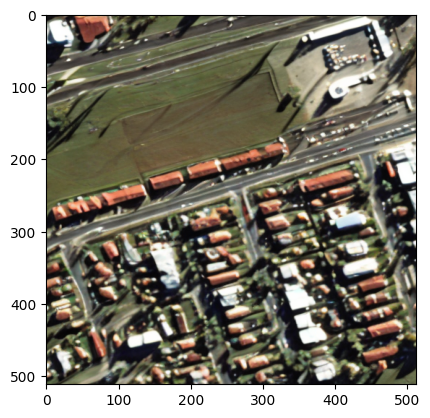

In [15]:
meta = metadata = metadata_normalize([
    -89.5712666476,      # longitude (degrees, -180 to 180)
    43.6965307997,      # latitude (degrees, -90 to 90)
    1.529417550564,     # GSD (Ground Sample Distance in meters)
    0.0,    # cloud cover (0 to 1)
    2024,               # year
    7,                  # month (1-12)
    1                  # day (1-31)
]).tolist()
image = pipe("A satellite image of a coffee shop next to TJ's house in the suburbs", metadata=meta, num_inference_steps=20, guidance_scale=7.5, height=512, width=512).images[0];plt.imshow(image);plt.show()

#### Prompt pipe 1

In [ ]:
image = pipe1(caption, num_inference_steps=50, guidance_scale=7.5, height=512, width=512).images[0]
image

# Pipe: Finetuning with metadata, SNR 5

In [ ]:
# If running on CPU (not recommended), then comment-out casting to float16 and the line which shifts the pipe to cuda

path = 'path/to/diffusion_sat_checkpoints/finetune_sd21_sn-satlas-fmow_snr5_md7norm_bs64/'
unet = SatUNet.from_pretrained(path + 'checkpoint-150000', subfolder="unet", torch_dtype=torch.float16)
pipe = DiffusionSatPipeline.from_pretrained(path, unet=unet, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

#### Prompt Pipe

Play around with guidance scale and number of inference steps to generate images

In [ ]:
image = pipe(caption, metadata=metadata, num_inference_steps=20, guidance_scale=7.5, height=512, width=512).images[0]
image